In [9]:
import pyvista as pv
import numpy as np
from typing import Any, Tuple
from importlib import reload
import multiprocessing
import ifcopenshell
import ifcopenshell.geom
import time
from functools import reduce
import open3d as o3d
import random
import glob
import os
import pandas as pd
from collections import defaultdict
import datetime
from csv import writer
import traceback

In [10]:
def random_color():
    """Generate a random RGB color."""
    return [random.random(), random.random(), random.random()]

def open3d_block_by_element(ifc_file): 
    # Configuration for ifcopenshell geometric settings
    settings = ifcopenshell.geom.settings()
    settings.set(settings.USE_WORLD_COORDS, True)
    settings.set(settings.APPLY_DEFAULT_MATERIALS, True)

    # Initialize the iterator for geometric representations
    iterator = ifcopenshell.geom.iterator(settings, ifc_file, multiprocessing.cpu_count())
    
    # Define entity types to include and exclude
    exclude_list = set(["IfcCovering", "IfcFurnishingElement", "IfcSpace", "IfcOpening", "IfcOpeningElement", "IfcRailing"])
    
    # Lists to store the resulting meshes and element information
    all_meshes = []
    element_information = {}
    
    # Variable to track the smallest dimension among all meshes
    temp_dimension_x = 0.8
    temp_dimension_y = 0.8
    temp_dimension_z = 0.8
    max_dimension = 0
    # Iterate over the geometric representations
    if iterator.initialize():
        index = 0
        while True:
            shape = iterator.get()
            
            # Check if the shape type is not excluded and represents an IfcBuildingElement
            if shape.type not in exclude_list and shape.product.is_a("IfcBuildingElement"):
                # Convert the shape's geometry to an Open3D mesh
                faces = np.array(shape.geometry.faces)
                verts = np.array(shape.geometry.verts).reshape(-1, 3)
                mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(verts),
                                                 triangles=o3d.utility.Vector3iVector(faces.reshape(-1, 3)))
                
                # Update the smallest dimension if necessary
                dimensions = mesh.get_max_bound() - mesh.get_min_bound()
                min_dimension_x, min_dimension_y, min_dimension_z = dimensions

                # Update temp_dimension_x, temp_dimension_y, temp_dimension_z if necessary
                if min(temp_dimension_x, min_dimension_x) > 0.1:
                    temp_dimension_x = min(temp_dimension_x, min_dimension_x)
                if min(temp_dimension_y, min_dimension_y) > 0.1:
                    temp_dimension_y = min(temp_dimension_y, min_dimension_y)

                # Store the mesh and its corresponding IFC GUID
                all_meshes.append(mesh)
                element_information[index] = shape.guid
                index += 1
                
                # Check if the shape is a slab and update the maximum x dimension if necessary
                if shape.type == "IfcSlab":
                    if min(temp_dimension_z, min_dimension_z) > 0.1:
                        temp_dimension_z = min(temp_dimension_z, min_dimension_z)                               
                    
            # Move to the next geometric representation
            if not iterator.next():
                
                break

    return all_meshes, element_information, round(temp_dimension_x,2), round(temp_dimension_y,2), round(temp_dimension_z,2)

def create_uniform_grid(bounds, voxel_size_x, voxel_size_y, voxel_size_z):
    """Create a uniform grid within the given bounds with rectangular cells."""
    x = np.arange(bounds[0], bounds[1] + voxel_size_x, voxel_size_x)
    y = np.arange(bounds[2], bounds[3] + voxel_size_y, voxel_size_y)
    z = np.arange(bounds[4], bounds[5] + voxel_size_z, voxel_size_z)
    return pv.StructuredGrid(*np.meshgrid(x, y, z))

def open3d_to_pyvista(point_cloud_o3d):
    """
    Convert an Open3D point cloud to a PyVista point cloud.

    Parameters:
    - point_cloud_o3d: The Open3D point cloud.

    Returns:
    - A PyVista `PolyData` object.
    """
    # Extract points from Open3D point cloud
    points = np.asarray(point_cloud_o3d.points)

    # Create a PyVista PolyData object
    point_cloud_pv = pv.PolyData(points)

    return point_cloud_pv

def process_point(pcd, mesh_guid_index, grid_bounds, x_size, y_size, z_size, dims, grid_attributes):
    j = int((pcd[0] - grid_bounds[0]) / x_size)
    i = int((pcd[1] - grid_bounds[2]) / y_size)
    k = int((pcd[2] - grid_bounds[4]) / z_size)
    
    if 0 <= i < dims[0]-1 and 0 <= j < dims[1]-1 and 0 <= k < dims[2]-1 and grid_attributes[i,j,k] == -1:
        grid_attributes[i,j,k] = mesh_guid_index

def voxelize_space(bounds, pcd_list, x_size, y_size, z_size):
    """Create a 3d grid and check the intersections of the meshes with the grid."""
    grid = create_uniform_grid(bounds, x_size, y_size, z_size)
    
    # create an empty 3d array in the same dimensions of the grid
    dims = grid.dimensions
    grid_attributes = np.full((dims[0]-1, dims[1]-1, dims[2]-1), -1, dtype=int)

    grid_bounds = grid.bounds
    
    [process_point(point, i, grid_bounds, x_size, y_size, z_size, dims, grid_attributes) 
    for i, pcd in enumerate(pcd_list) for point in pcd.points]

    # assign empty array to the grid
    grid.cell_data['attributes'] = grid_attributes.flatten(order='F').astype(int)
    
    return grid

def get_sampling_points(mesh, voxel_size, points_per_unit_area=120):
    
    # Calculate the surface area of the mesh
    area = mesh.get_surface_area()

    # Calculate the number of points to sample
    N = int(area * points_per_unit_area*1/voxel_size)
        
    return N

def create_point_cloud(all_meshes, x_size):
    """Create a point cloud from a mesh."""

    pcd_list = []

    for mesh in all_meshes:
        # Get the number of points to sample based on the mesh size
        N = get_sampling_points(mesh, x_size)
        pcd = mesh.sample_points_uniformly(N)
        pcd_pv = open3d_to_pyvista(pcd)
        pcd_list.append(pcd_pv)  
        
    return pcd_list


def fetch_element_quantities(ifc_file, grid, x_size, y_size, z_size, element_information):
    # Fetch all property sets named 'ZECH_ATTRIBUTE'
    property_sets = ifc_file.by_type("IfcPropertySet")
    zech_property_sets = [ps for ps in property_sets if ps.Name == "ZECH_ATTRIBUTE"]
    
    # Create a mapping of elements to their ZB_AUSWAHL values
    element_to_zb_auswahl = {}
    for ps in zech_property_sets:
        for prop in ps.HasProperties:
            if prop.is_a("IfcPropertySingleValue") and prop.Name == "ZB_AUSWAHL":
                # Find all elements that have this property set
                for rel in ifc_file.by_type("IfcRelDefinesByProperties"):
                    if rel.RelatingPropertyDefinition == ps:
                        for related_object in rel.RelatedObjects:
                            element_to_zb_auswahl[related_object.GlobalId] = str(prop.NominalValue.wrappedValue)
    
    element_volumes = defaultdict(int)
    
    # Calculate volumes
    for att in grid.cell_data['attributes']:
        element_guid = element_information.get(att)
        zb_auswahl_value = element_to_zb_auswahl.get(element_guid)
        if zb_auswahl_value is not None:
            element_volumes[zb_auswahl_value] += 1
    
    # Convert counts to volumes
    for zb_auswahl_value, count in element_volumes.items():
        element_volumes[zb_auswahl_value] = round(count * x_size * y_size * z_size, 3)
    
    return element_volumes


def process_ifc_file(file_name, writer):
    try:
        
        pv.set_plot_theme("document")
        pv.global_theme.window_size = [1024, 768]
        pv.global_theme.jupyter_backend = 'static'
        p = pv.Plotter()
        ifc_file = ifcopenshell.open(file_name)
        print(file_name)

        ### CONVERSION FROM IFC TO MESH ###
        print(f'Converting {file_name}...')

        start_time = time.time()
        all_meshes, element_information, x_size, y_size, z_size = open3d_block_by_element(ifc_file)

        total_polygons = sum(len(mesh.triangles) for mesh in all_meshes)

        # combine all meshes into one mesh and find the bounds
        combined_mesh = reduce(lambda m1, m2: m1 + m2, all_meshes)

       
        end_time = time.time()
        conversion_time = end_time - start_time


        ### POINT CLOUD CREATION ###
        print(f'Point cloud formation representing {file_name}...')
        start_time = time.time()
        point_cloud_list  = create_point_cloud(all_meshes, x_size)
        
        #merge all the list of point clouds into one
        pcd_pv = pv.PolyData()
        pcd_pv.points = np.vstack(list(map(lambda x: x.points, point_cloud_list)))
        sampling_points = len(pcd_pv.points)
        end_time = time.time()
        point_cloud_processing = end_time - start_time

        print(f'Rasterizing {file_name}...')
        start_time = time.time()

        # Compute the oriented bounding box (OBB)
        bb = combined_mesh.get_axis_aligned_bounding_box()
        
        # Extract the eight corner points of the OBB
        bb_points = np.asarray(bb.get_box_points())

        # Compute the axis-aligned bounding box of these eight points
        xmin, ymin, zmin = np.min(bb_points, axis=0)
        xmax, ymax, zmax = np.max(bb_points, axis=0)

        bounds = np.array([xmin, xmax, ymin, ymax, zmin, zmax])
        
        ### RASTERIZATION ###
        
        grid = voxelize_space(bounds, point_cloud_list, x_size, y_size, z_size)
        end_time = time.time()
        rasterization_time = end_time - start_time
        
        end_time = time.time()
        rasterization_time = end_time - start_time        

        ### VISUALIZATION ###
        print(f'Visualizing {file_name}...')
        start_time = time.time()
         
        # Extract the cells with non-empty attribute values
        non_empty_cells = grid.cell_data['attributes'] != -1  
        # Create a box from the bounds
        box = pv.Box(bounds=bounds)

        # Add the box to the plotter
        p.add_mesh(box, color="blue", style="wireframe", line_width=2)
        # Add the mesh to the plotter with the non-empty cells
        p.add_mesh(grid.extract_cells(non_empty_cells), opacity=0.5, show_edges=False,show_scalar_bar=False)
        
        screenshot_filename = os.path.join("screenshots", os.path.basename(file_name) + ".png")
        p.screenshot(screenshot_filename)
        end_time = time.time()
        visualization_time = end_time - start_time
        p.show()
         # Store the results in a dictionary
        results = {}
        results['File'] = file_name
        results['# of Polygons'] = total_polygons
        results['# of Points'] = sampling_points
        results['Cell Size (m)'] = x_size, y_size, z_size
        results['Conversion (sec)'] = round(conversion_time,2)
        results['Point Cloud Creation (sec)'] = round(point_cloud_processing,2)
        results['Rasterization (sec)'] = round(rasterization_time,2)
        results['Visualization (sec)'] = round(visualization_time,2)
        
        print(f'Calculating quantities in {file_name}...')
        
        start_time = time.time()
        element_volumes = fetch_element_quantities(ifc_file, grid, x_size, y_size, z_size, element_information)

        results_QTO = {}

        # Store the concrete volumes for different ZB_AUSWAHL values
        for zb_auswahl_value, volume in element_volumes.items():
            results_QTO[f'{zb_auswahl_value}'] = volume

        end_time = time.time()
        quantity_calculation_time = end_time - start_time
        results['Quantity Calculation (sec)'] = round(quantity_calculation_time,2)

        print(results)
        print(results_QTO)

        # Write results to Excel
        df_results = pd.DataFrame([results])
        df_results_QTO = pd.DataFrame([results_QTO])
        df_results_QTO = df_results_QTO

        # Find the last row in the Excel sheets
        last_row_results = writer.sheets['Results'].max_row
        last_row_qto = writer.sheets['QTO'].max_row

        # Write the dataframes to Excel, starting at the last row
        df_results.to_excel(writer, sheet_name='Results', startrow=last_row_results, index=False, header=False)
        df_results_QTO.T.to_excel(writer, sheet_name='QTO', startrow=last_row_qto, header=True)
        screenshot_filename = os.path.join("screenshots", os.path.basename(file_name) + ".png")
        p.screenshot(screenshot_filename)

        # Ensure that the writer object is returned'''
        return writer

    except FileNotFoundError:
        print(f"Error: {file_name} not found.")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}

    except MemoryError:
        print(f"Error: Insufficient memory to process {file_name}.")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}

    except (TypeError, ValueError) as e:
        print(f"Error processing {file_name}: {str(e)}")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}

    except Exception as e:
        print(f"An unexpected error occurred while processing {file_name}: {str(e)}")
        print("Here's the traceback:")
        traceback.print_exc()
        return {}, {}
    
def find_ifc_files(directory):
    """Find all IFC files in a given directory."""
    # Use os.path.join to ensure the path is constructed correctly for any OS
    search_path = os.path.join(directory, "*.ifc")
    return glob.glob(search_path)

In [11]:
'''# Get the current date and time
now = datetime.datetime.now()

# Format the date and time as a string: YYYYMMDD_HHMMSS
formatted_time = now.strftime("%Y_%m_%d")

# Create a filename using the formatted time
filename = f"output_{formatted_time}.xlsx"

# Ensure the writer context is used when calling process_ifc_file
with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    
    # Create initial empty DataFrames to set up the Excel sheets
    pd.DataFrame(columns=['File', '# of Polygons', '# of Points', 'Cell Size (m)', 'Conversion Time (sec)', 'Point Cloud Creation Time (sec)', 'Rasterization (sec)', 'Visualization (sec)', 'Concrete Calculation Time (sec)']).to_excel(writer, sheet_name='Results')
    pd.DataFrame().to_excel(writer, sheet_name='QTO')  # Add appropriate columns if needed
    
    # Call process_ifc_file within the writer context
    process_ifc_file("IFC Files/01_Test.ifc", writer)'''

'# Get the current date and time\nnow = datetime.datetime.now()\n\n# Format the date and time as a string: YYYYMMDD_HHMMSS\nformatted_time = now.strftime("%Y_%m_%d")\n\n# Create a filename using the formatted time\nfilename = f"output_{formatted_time}.xlsx"\n\n# Ensure the writer context is used when calling process_ifc_file\nwith pd.ExcelWriter(filename, engine=\'openpyxl\') as writer:\n    \n    # Create initial empty DataFrames to set up the Excel sheets\n    pd.DataFrame(columns=[\'File\', \'# of Polygons\', \'# of Points\', \'Cell Size (m)\', \'Conversion Time (sec)\', \'Point Cloud Creation Time (sec)\', \'Rasterization (sec)\', \'Visualization (sec)\', \'Concrete Calculation Time (sec)\']).to_excel(writer, sheet_name=\'Results\')\n    pd.DataFrame().to_excel(writer, sheet_name=\'QTO\')  # Add appropriate columns if needed\n    \n    # Call process_ifc_file within the writer context\n    process_ifc_file("IFC Files/01_Test.ifc", writer)'

IFC Files\01_Test.ifc
Converting IFC Files\01_Test.ifc...
Point cloud formation representing IFC Files\01_Test.ifc...
Rasterizing IFC Files\01_Test.ifc...
Visualizing IFC Files\01_Test.ifc...


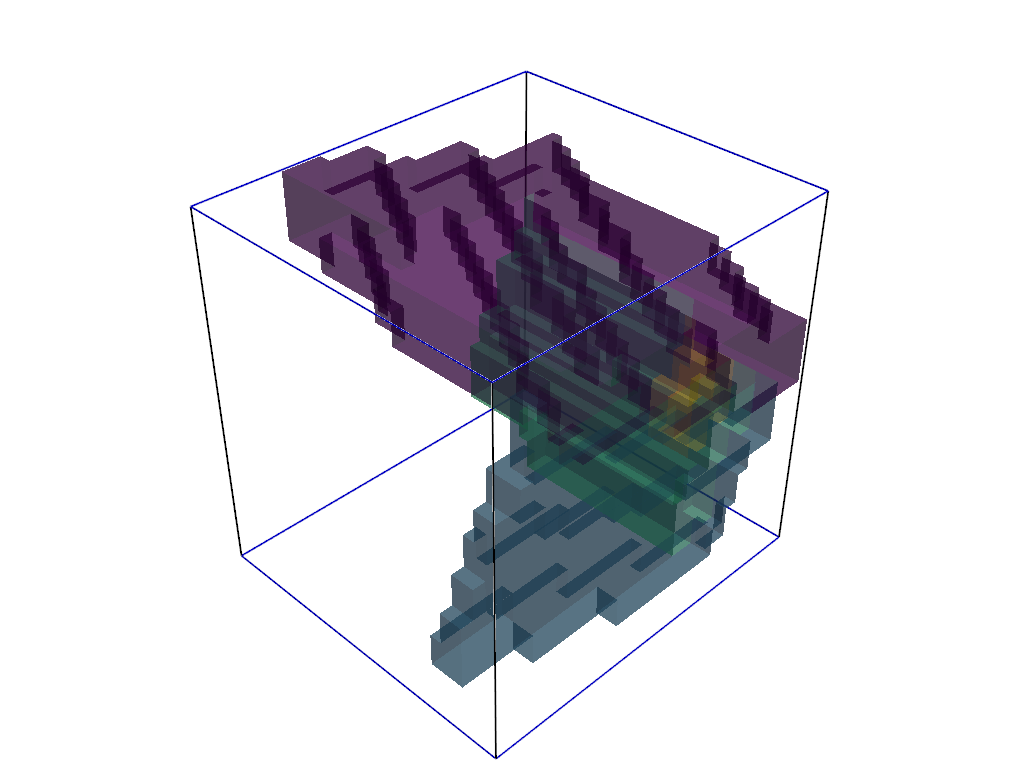

Calculating quantities in IFC Files\01_Test.ifc...
{'File': 'IFC Files\\01_Test.ifc', '# of Polygons': 1056, '# of Points': 71470, 'Cell Size (m)': (0.2, 0.18, 0.48), 'Conversion (sec)': 0.12, 'Point Cloud Creation (sec)': 0.02, 'Rasterization (sec)': 0.32, 'Visualization (sec)': 0.19, 'Quantity Calculation (sec)': 0.0}
{}
IFC Files\02_Duplex.ifc
Converting IFC Files\02_Duplex.ifc...
Point cloud formation representing IFC Files\02_Duplex.ifc...
Rasterizing IFC Files\02_Duplex.ifc...
Visualizing IFC Files\02_Duplex.ifc...


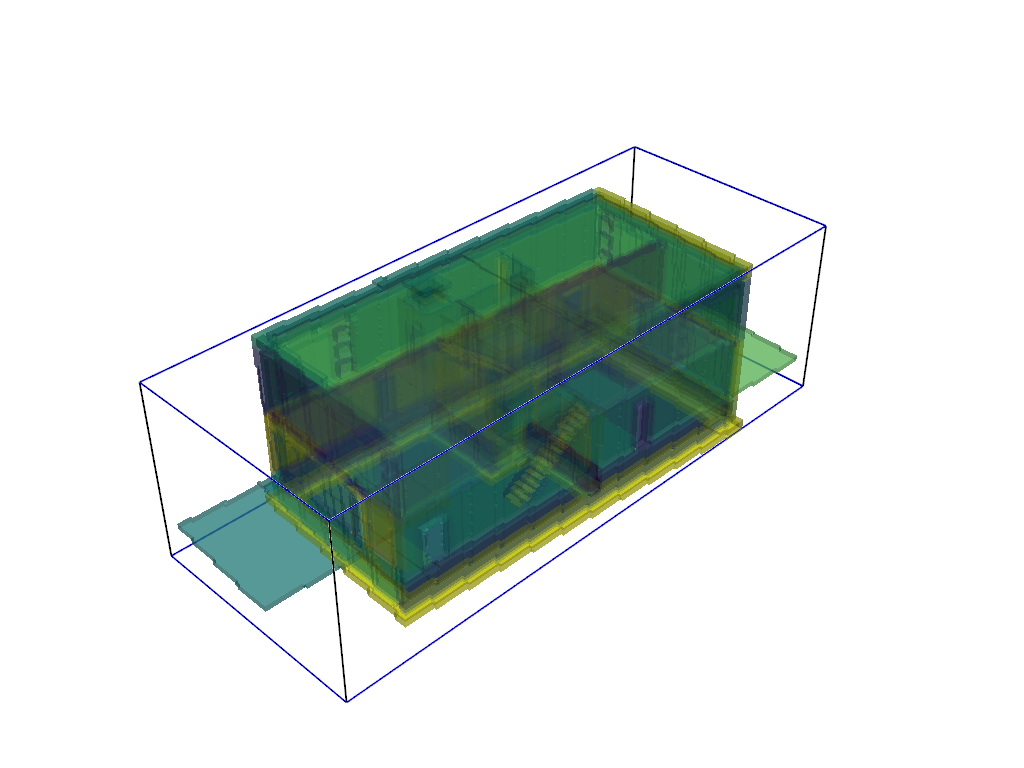

Calculating quantities in IFC Files\02_Duplex.ifc...
{'File': 'IFC Files\\02_Duplex.ifc', '# of Polygons': 9420, '# of Points': 3598348, 'Cell Size (m)': (0.12, 0.12, 0.13), 'Conversion (sec)': 3.13, 'Point Cloud Creation (sec)': 0.66, 'Rasterization (sec)': 15.16, 'Visualization (sec)': 0.38, 'Quantity Calculation (sec)': 0.29}
{}
IFC Files\03_Clinic.ifc
Converting IFC Files\03_Clinic.ifc...
Point cloud formation representing IFC Files\03_Clinic.ifc...
Rasterizing IFC Files\03_Clinic.ifc...
Visualizing IFC Files\03_Clinic.ifc...


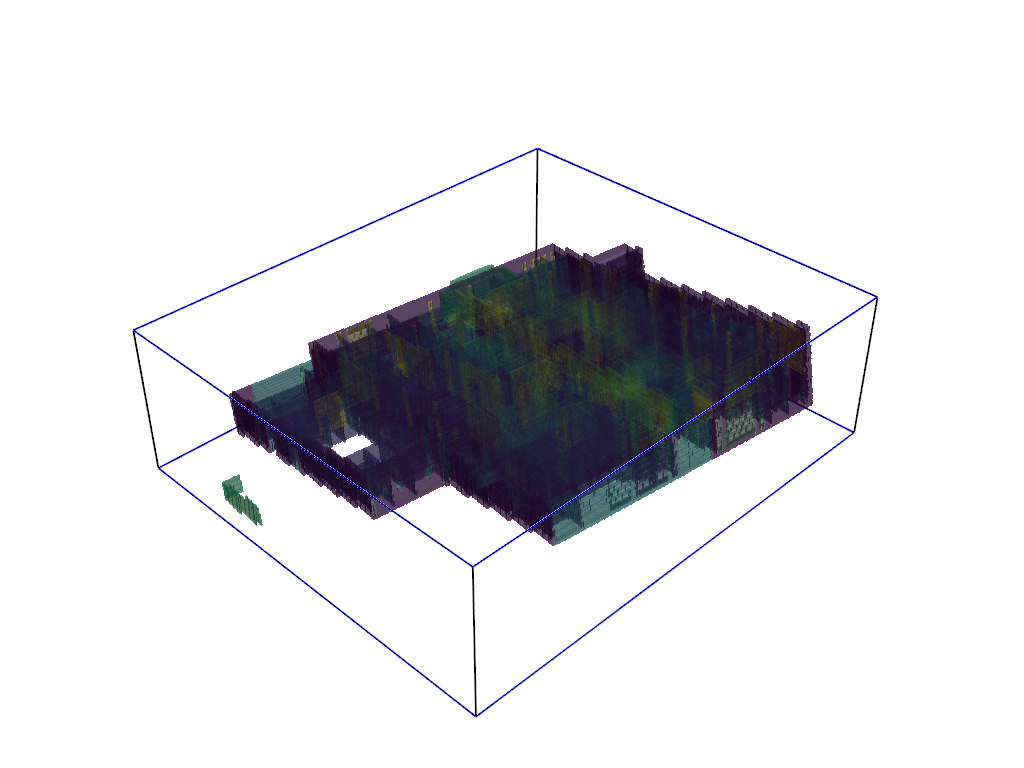

Calculating quantities in IFC Files\03_Clinic.ifc...
{'File': 'IFC Files\\03_Clinic.ifc', '# of Polygons': 63182, '# of Points': 31356112, 'Cell Size (m)': (0.11, 0.11, 0.8), 'Conversion (sec)': 23.01, 'Point Cloud Creation (sec)': 5.32, 'Rasterization (sec)': 135.05, 'Visualization (sec)': 0.75, 'Quantity Calculation (sec)': 2.22}
{}
IFC Files\04.ifc
Converting IFC Files\04.ifc...
Point cloud formation representing IFC Files\04.ifc...
Rasterizing IFC Files\04.ifc...
Visualizing IFC Files\04.ifc...


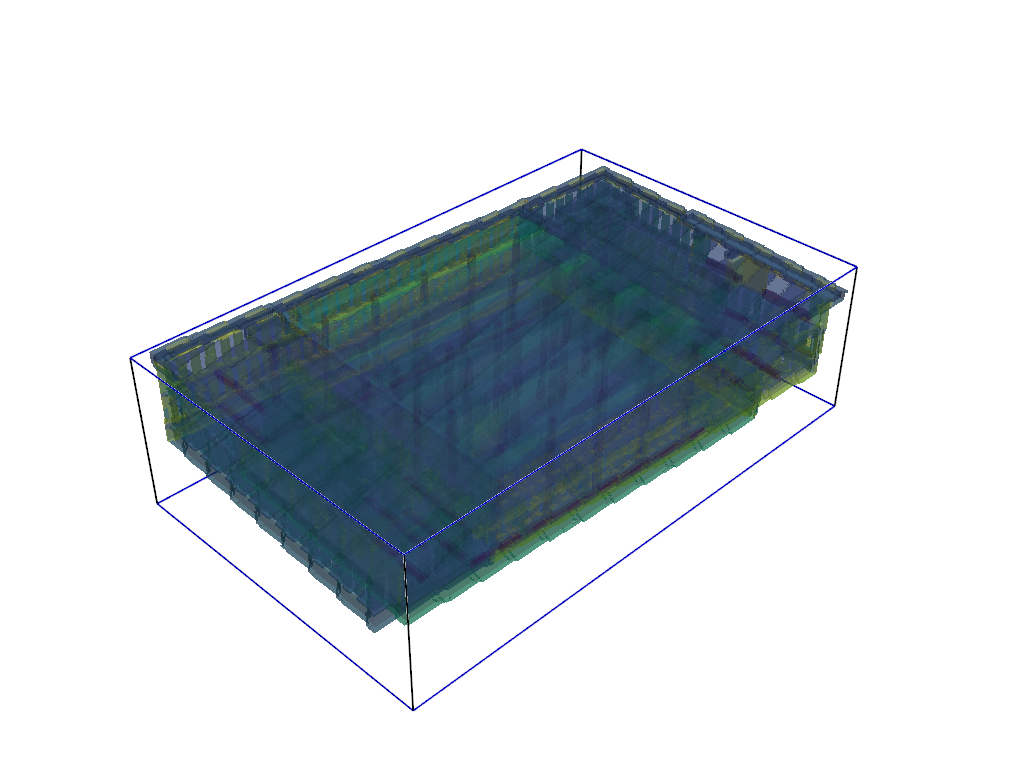

Calculating quantities in IFC Files\04.ifc...
{'File': 'IFC Files\\04.ifc', '# of Polygons': 16440, '# of Points': 18199404, 'Cell Size (m)': (0.29, 0.3, 0.16), 'Conversion (sec)': 3.08, 'Point Cloud Creation (sec)': 3.13, 'Rasterization (sec)': 86.34, 'Visualization (sec)': 0.75, 'Quantity Calculation (sec)': 1.26}
{'ZB_STB_ATT': 360.291, 'ZB_ORT_DECKE': 2284.523, 'ZB_ORT_W': 2121.366, 'ZB_STB_UZ': 92.735, 'ZB_RECK_ST': 211.403, 'ZB_KS_MW': 729.157, 'ZB_FT_TRH': 40.855, 'ZB_ORT_POD': 19.098, 'ZB_SOHLE': 938.779, 'ZB_PERI_BO': 329.236, 'ZB_STR_FUN': 621.96, 'ZB_PERI_W': 44.182, 'ZB_UNTF': 8.964, 'ZB_P_FUN': 37.25}
IFC Files\05.ifc
Converting IFC Files\05.ifc...
Point cloud formation representing IFC Files\05.ifc...
Rasterizing IFC Files\05.ifc...
Visualizing IFC Files\05.ifc...


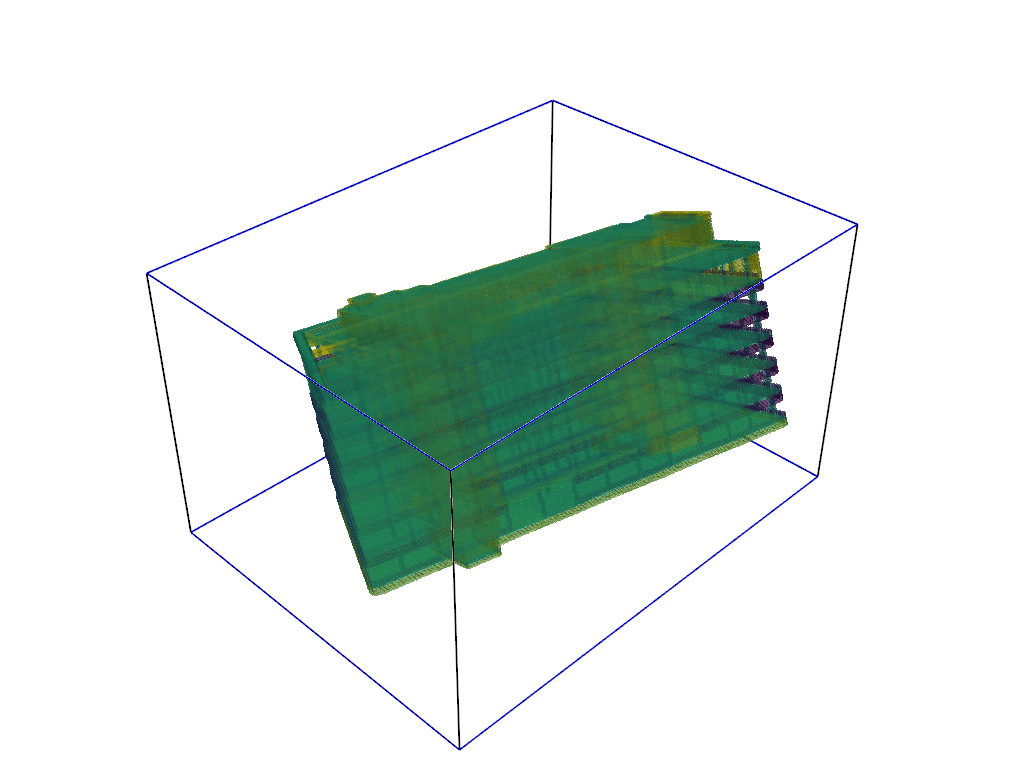

Calculating quantities in IFC Files\05.ifc...
{'File': 'IFC Files\\05.ifc', '# of Polygons': 39244, '# of Points': 42776612, 'Cell Size (m)': (0.15, 0.11, 0.18), 'Conversion (sec)': 7.4, 'Point Cloud Creation (sec)': 7.12, 'Rasterization (sec)': 205.77, 'Visualization (sec)': 4.61, 'Quantity Calculation (sec)': 13.91}
{'ZB_STB_ATT': 85.563, 'ZB_ORT_DECKE': 4967.444, 'ZB_STB_UZ': 340.454, 'ZB_RECK_ST': 289.415, 'ZB_STB_ÜZ': 480.591, 'ZB_ORT_W': 1032.381, 'ZB_Z_MW': 248.247, 'ZB_FT_TRH': 93.594, 'ZB_FT_POD': 37.449, 'ZB_RU_ST': 8.922, 'ZB_SOHLE': 880.198, 'ZB_STR_FUN': 194.588, 'ZB_PERI_BO': 5.382, 'ZB_PERI_W': 167.888, 'ZB_ORT_UGW': 205.586, 'ZB_UNTF': 4.324, 'ZB_P_FUN': 12.367, 'ZB_ORT_WRU': 1.892}
IFC Files\06.ifc
Converting IFC Files\06.ifc...
Point cloud formation representing IFC Files\06.ifc...
Rasterizing IFC Files\06.ifc...
Visualizing IFC Files\06.ifc...


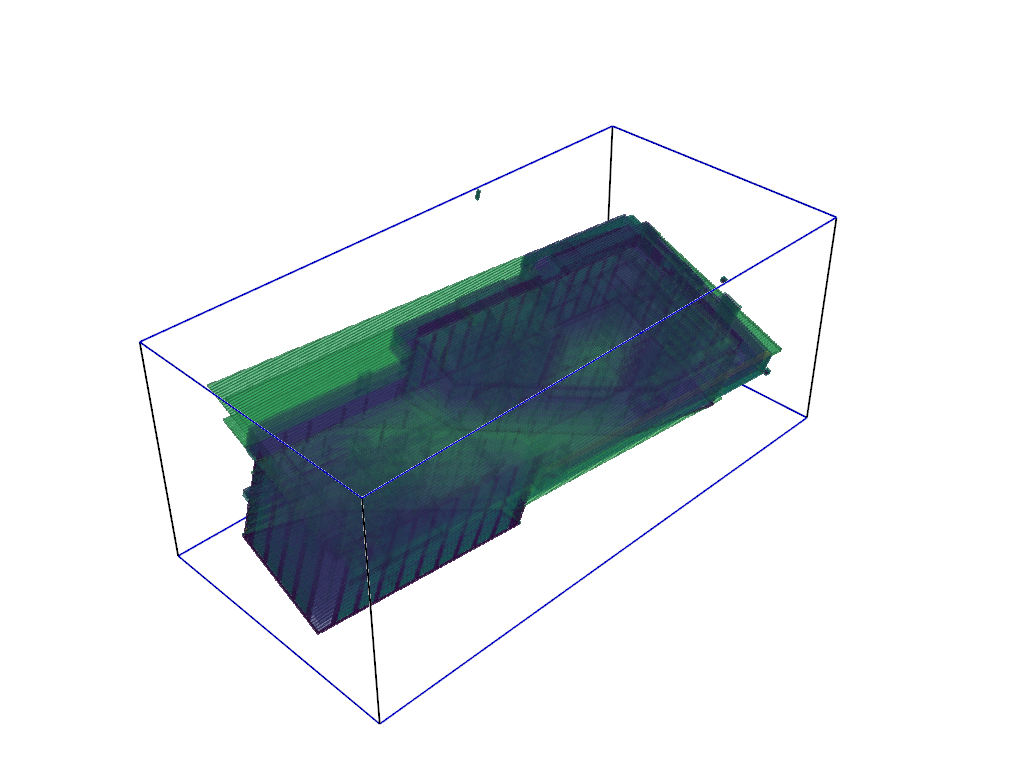

Calculating quantities in IFC Files\06.ifc...
{'File': 'IFC Files\\06.ifc', '# of Polygons': 120582, '# of Points': 298320255, 'Cell Size (m)': (0.11, 0.11, 0.2), 'Conversion (sec)': 37.52, 'Point Cloud Creation (sec)': 52.27, 'Rasterization (sec)': 1393.07, 'Visualization (sec)': 14.89, 'Quantity Calculation (sec)': 54.01}
{'ZB_STB_ATT': 171.735, 'ZB_ORT_DECKE': 17724.203, 'ZB_ORT_W': 3949.561, 'ZB_RU_STSR': 188.327, 'ZB_RU_ST': 169.56, 'ZB_RECK_ST': 183.003, 'ZB_Z_MW': 189.52, 'ZB_STB_ÜZ': 76.003, 'ZB_KS_MW': 9.232, 'ZB_VER': 245.683, 'ZB_ORT_UGW': 883.133, 'ZB_STB_UZ': 89.997, 'ZB_PERI_W': 62.705, 'ZB_SOHLE': 2793.137, 'ZB_ORT_WRU': 13.056}
IFC Files\07.ifc
Converting IFC Files\07.ifc...
Point cloud formation representing IFC Files\07.ifc...
Rasterizing IFC Files\07.ifc...
Visualizing IFC Files\07.ifc...


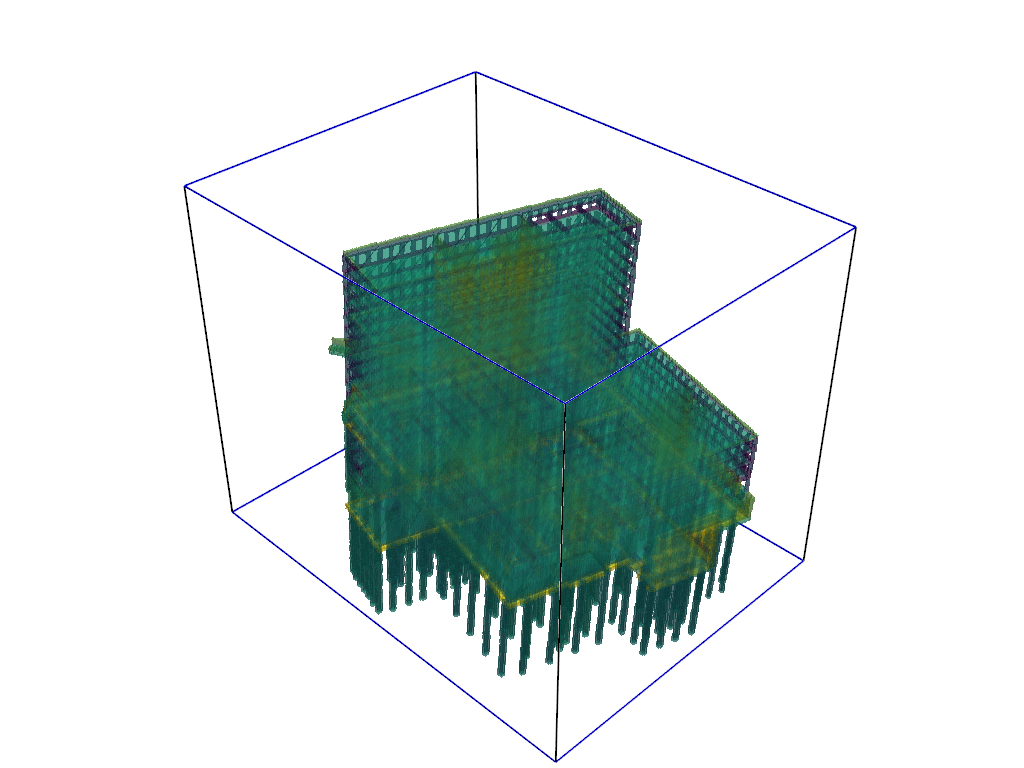

Calculating quantities in IFC Files\07.ifc...
{'File': 'IFC Files\\07.ifc', '# of Polygons': 213015, '# of Points': 82940472, 'Cell Size (m)': (0.3, 0.29, 0.26), 'Conversion (sec)': 39.78, 'Point Cloud Creation (sec)': 15.1, 'Rasterization (sec)': 377.38, 'Visualization (sec)': 3.09, 'Quantity Calculation (sec)': 14.31}
{'ZB_BPH': 9073.425, 'ZB_STR_FUN': 618.725, 'ZB_P_FUN': 142.732, 'ZB_SOHLE': 3479.273, 'ZB_ORT_UGW': 1932.133, 'ZB_RU_ST': 19.069, 'ZB_RECK_ST': 3044.969, 'ZB_ORT_DECKE': 22319.471, 'ZB_ORT_W': 9633.225, 'ZB_KS_MW': 334.188, 'ZB_ORT_RAMPE': 441.158, 'ZB_ORT_WRU': 37.911, 'ZB_ORT_UGWRU': 62.838, 'ZB_STB_UZ': 1332.16, 'ZB_STB_ÜZ': 2575.445, 'ZB_STB_ATT': 247.96}
IFC Files\08.ifc
Converting IFC Files\08.ifc...
Point cloud formation representing IFC Files\08.ifc...
Rasterizing IFC Files\08.ifc...
Visualizing IFC Files\08.ifc...


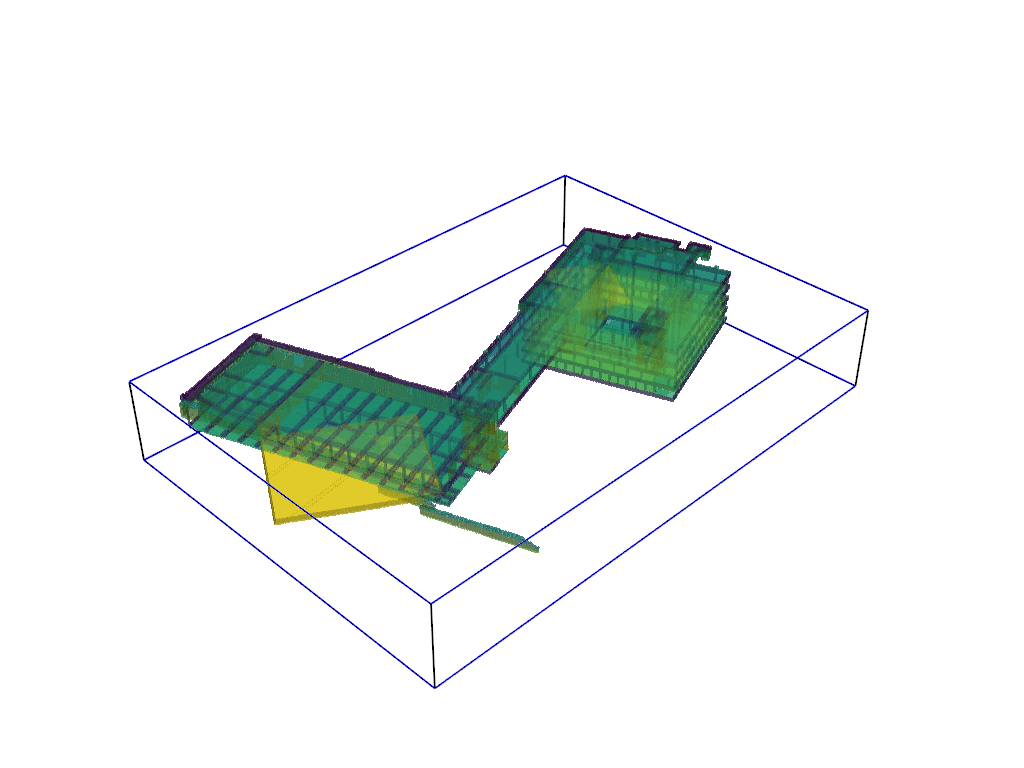

Calculating quantities in IFC Files\08.ifc...
{'File': 'IFC Files\\08.ifc', '# of Polygons': 67792, '# of Points': 27733882, 'Cell Size (m)': (0.25, 0.22, 0.13), 'Conversion (sec)': 21.93, 'Point Cloud Creation (sec)': 4.6, 'Rasterization (sec)': 131.52, 'Visualization (sec)': 2.3, 'Quantity Calculation (sec)': 15.98}
{'ZB_STB_ATT': 167.81, 'ZB_ORT_DECKE': 2969.038, 'ZB_ORT_W1': 1748.718, 'ZB_RECK_ST': 175.847, 'ZB_RU_ST': 145.467, 'ZB_STB_ÜZ': 397.09, 'ZB_FT_POD': 16.788, 'ZB_STB_UZ': 956.162, 'ZB_KS_MW': 56.07, 'ZB_FT_VOW': 170.091, 'ZB_ORT_UGW': 392.885, 'ZB_SOHLE': 1222.493, 'ZB_FT_LS': 7.929, 'ZB_PKB': 635.328, 'ZB_STR_FUN': 36.243, 'ZB_BPK': 43.594}
IFC Files\09.ifc
Converting IFC Files\09.ifc...
Point cloud formation representing IFC Files\09.ifc...
Rasterizing IFC Files\09.ifc...
Error: Insufficient memory to process IFC Files\09.ifc.
Here's the traceback:


Traceback (most recent call last):
  File "C:\Users\Laptop\AppData\Local\Temp\ipykernel_20540\161500376.py", line 279, in process_ifc_file
    grid = voxelize_space(bounds, point_cloud_list, x_size, y_size, z_size)
  File "C:\Users\Laptop\AppData\Local\Temp\ipykernel_20540\161500376.py", line 102, in voxelize_space
    grid = create_uniform_grid(bounds, x_size, y_size, z_size)
  File "C:\Users\Laptop\AppData\Local\Temp\ipykernel_20540\161500376.py", line 72, in create_uniform_grid
    return pv.StructuredGrid(*np.meshgrid(x, y, z))
  File "c:\Users\Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\core\pointset.py", line 2091, in __init__
    self._from_arrays(uinput, y, z, **kwargs)
  File "c:\Users\Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\core\pointset.py", line 2141, in _from_arrays
    points[:, 0] = x.ravel('F')
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 8.08 GiB for an array with shape (1084547971,) and data

IFC Files\10.ifc
Converting IFC Files\10.ifc...
Point cloud formation representing IFC Files\10.ifc...
Rasterizing IFC Files\10.ifc...
Visualizing IFC Files\10.ifc...


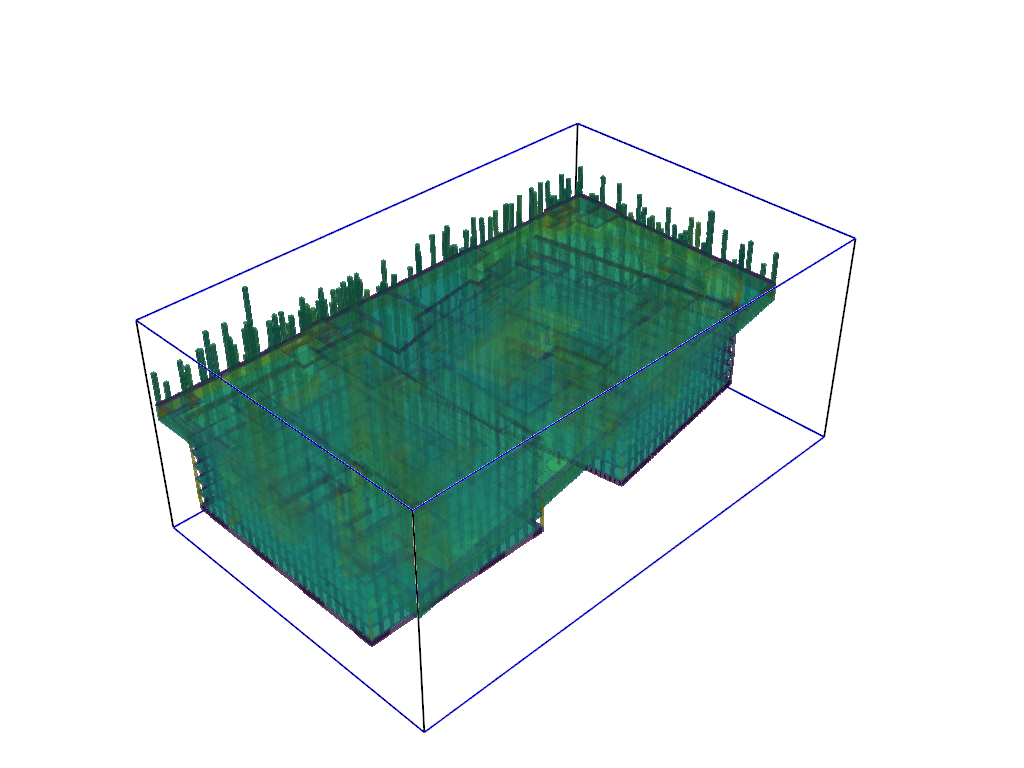

Calculating quantities in IFC Files\10.ifc...
{'File': 'IFC Files\\10.ifc', '# of Polygons': 370959, '# of Points': 108643912, 'Cell Size (m)': (0.18, 0.17, 0.11), 'Conversion (sec)': 100.67, 'Point Cloud Creation (sec)': 19.62, 'Rasterization (sec)': 508.91, 'Visualization (sec)': 9.17, 'Quantity Calculation (sec)': 48.71}
{'ZB_ORT_DECKE': 7769.23, 'ZB_FT_W': 2464.828, 'ZB_ORT_W': 2410.753, 'ZB_STB_UZ': 864.096, 'ZB_RECK_ST': 426.651, 'ZB_FT_RECK_ST': 1444.105, 'ZB_ORT_POD': 48.258, 'ZB_VB_T': 55.569, 'ZB_VB_ST': 6.867, 'ZB_STB_ATT': 4.982, 'ZB_RU_ST': 30.005, 'ZB_ORT_UGWRU': 38.13, 'ZB_FT_ERDW': 454.376, 'ZB_ORT_RAMPE': 70.39, 'ZB_SOHLE': 2184.231, 'ZB_PKB': 481.489, 'ZB_BPK': 65.132, 'ZB_UNTF': 31.156, 'ZB_BPF': 2479.934}


In [12]:
directory_path = "IFC Files/"
ifc_files = find_ifc_files(directory_path)

# Get the current date and time
now = datetime.datetime.now()

# Format the date and time as a string: YYYYMMDD_HHMMSS
formatted_time = now.strftime("%Y%m%d")

# Create a filename using the formatted time
filename = f"output_{formatted_time}_affine.xlsx"

# Create an Excel writer object
# Ensure the writer context is used when calling process_ifc_file
with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    # Create initial empty DataFrames to set up the Excel sheets
    pd.DataFrame(columns=['File', '# of Polygons', '# of Points', 'Cell Size (m)', 'Conversion Time (sec)', 'Point Cloud Creation Time (sec)', 'Rasterization (sec)', 'Visualization (sec)', 'Concrete Calculation Time (sec)']).to_excel(writer, sheet_name='Results')
    pd.DataFrame().to_excel(writer, sheet_name='QTO')  # Add appropriate columns if needed
      
    # Process each IFC file and write the results to Excel
    for file_name in ifc_files:
        process_ifc_file(file_name, writer)
